In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

from import_preprocess import ImportPreprocess
from evaluate import Evaluation

In [2]:
import_preprocess = ImportPreprocess()
import_preprocess.import_train_dev_test()

X_train, y_train = import_preprocess.X_train, import_preprocess.y_train
X_dev, y_dev = import_preprocess.X_dev, import_preprocess.y_dev
X_test, y_test = import_preprocess.X_test, import_preprocess.y_test

import_preprocess.convert_class_labels()
y_train, y_dev, y_test = import_preprocess.y_train, import_preprocess.y_dev, import_preprocess.y_test

print(X_train[1])

['like', 'metallica', 'video', 'poor', 'mutilated', 'bastard', 'saying', '``', 'please', 'kill', "''", ',', 'emojis', 'instead', 'morse', 'code', '.']


In [3]:
class LSTM_Model():
    def __init__(self):
        self.model = None
        self.tokenizer = None
        
    def fit_tokenizer(self, X_train):
        self.tokenizer = Tokenizer()
        self.tokenizer.fit_on_texts(X_train)
    
    def prepare_X(self, X):
        seq = self.tokenizer.texts_to_sequences(X)
        padded = pad_sequences(seq, padding='post')
        return padded
        
    def initialize_model(self, vocab_size):
        model = Sequential()
        model.add(Embedding(input_dim = vocab_size, output_dim = 64))
        model.add(LSTM(32))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
        return model
    
    def fit(self, X_train, y_train, X_dev, y_dev):
        self.fit_tokenizer(X_train)
        vocab_size = len(self.tokenizer.word_index) + 1
        
        X_train = self.prepare_X(X_train)
        X_dev = self.prepare_X(X_dev)
        y_train = np.array(y_train)
        y_dev = np.array(y_dev)
        
        self.model = self.initialize_model(vocab_size)
        self.model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_dev, y_dev))
        
    def predict(self, X):
        X = self.prepare_X(X)
        probs = self.model.predict(X)
        y_pred = (probs > 0.5).astype(int)
        return y_pred

In [4]:
rnn = LSTM_Model()
rnn.fit(X_train, y_train, X_dev, y_dev)

Epoch 1/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.7579 - loss: 0.5593 - val_accuracy: 0.7560 - val_loss: 0.5515
Epoch 2/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.7585 - loss: 0.5430 - val_accuracy: 0.6580 - val_loss: 0.5388
Epoch 3/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.7719 - loss: 0.5060 - val_accuracy: 0.7730 - val_loss: 0.4954
Epoch 4/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.8051 - loss: 0.4666 - val_accuracy: 0.8110 - val_loss: 0.4585
Epoch 5/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.8538 - loss: 0.3718 - val_accuracy: 0.8225 - val_loss: 0.4253
Epoch 6/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.8768 - loss: 0.3180 - val_accuracy: 0.8285 - val_loss: 0.4152
Epoch 7/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.8940 - loss: 0.2861 - val_accuracy: 0.8260 - val_loss: 0.4522
Epoch 8/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9138 - loss: 0.2480 - val_accu

438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Metrics for TRAIN+DEV set
accuracy: 0.9485
balanced accuracy: 0.9135
precision: 0.9361
recall: 0.8455
########################################

Metrics for TEST set
accuracy: 0.8130
balanced accuracy: 0.7102
precision: 0.6458
recall: 0.5103


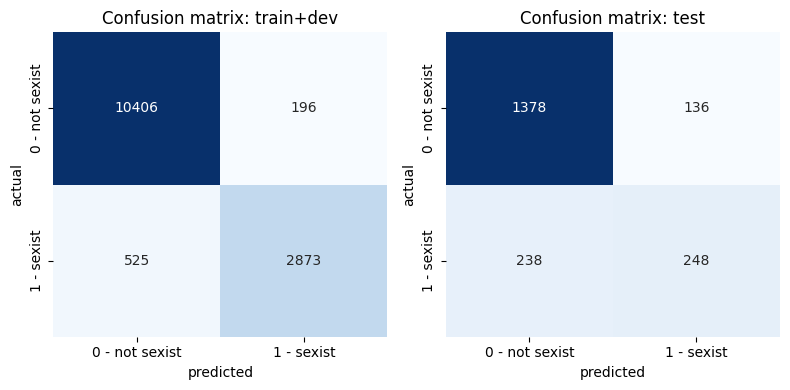

In [5]:
eval_baseline = Evaluation(model=rnn)
eval_baseline.evaluate(X_train, y_train, X_dev, y_dev, plot_confusion=True)

In [6]:
def convert_class_labels(#self, 
                         y):
    """
    'sexist' -> 1, 'not sexist' -> 0
    """
    encoded = [1 if label == "sexist" else 0 for label in y]
    return encoded
    
def convert_class_labels_back(#self,
                              y):
    """
    1 -> 'sexist', 0 -> 'not sexist'
    """
    decoded = ["sexist" if label == 1 else "not sexist" for label in y]
    return decoded

In [7]:
convert_class_labels_back(y_dev[:10])

['not sexist',
 'not sexist',
 'sexist',
 'sexist',
 'not sexist',
 'not sexist',
 'not sexist',
 'sexist',
 'not sexist',
 'sexist']

In [8]:
def create_balanced_dataset(X, y, n_samples=5000):
    """
    Create a balanced dataset by sampling n_samples from each class.
    """
    y = np.array(y)
    
    class_0_indices = np.where(y == 0)[0]
    class_1_indices = np.where(y == 1)[0]
    
    sampled_class_0_indices = np.random.choice(class_0_indices, size=n_samples, replace=True)
    sampled_class_1_indices = np.random.choice(class_1_indices, size=n_samples, replace=True)

    balanced_indices = np.concatenate([sampled_class_0_indices, sampled_class_1_indices])
    np.random.shuffle(balanced_indices) 

    X_balanced = [X[i] for i in balanced_indices]
    y_balanced = [y[i] for i in balanced_indices]
    
    return X_balanced, y_balanced

In [9]:
X_balanced, y_balanced = create_balanced_dataset(X_train, y_train)

Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.4906 - loss: 0.6944 - val_accuracy: 0.2430 - val_loss: 0.6991
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.5005 - loss: 0.6933 - val_accuracy: 0.7135 - val_loss: 0.6302
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.6379 - loss: 0.6374 - val_accuracy: 0.7410 - val_loss: 0.5607
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8114 - loss: 0.4644 - val_accuracy: 0.6855 - val_loss: 0.6327
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8772 - loss: 0.3285 - val_accuracy: 0.7465 - val_loss: 0.5883
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9142 - loss: 0.2483 - val_accuracy: 0.7360 - val_loss: 0.6569
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9348 - loss: 0.1970 - val_accuracy: 0.7705 - val_loss: 0.6298
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9431 - loss: 0.1733 - val_accuracy: 0.

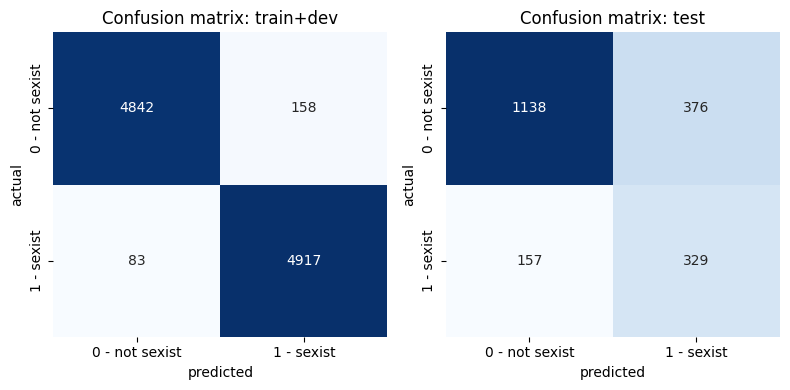

In [10]:
rnn.fit(X_balanced, y_balanced, X_dev, y_dev)
eval_baseline.evaluate(X_balanced, y_balanced, X_dev, y_dev, plot_confusion=True)